In [1]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from pathlib import Path
from bayes_opt import BayesianOptimization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import optuna

# 解决中文乱码问题
plt.rcParams["font.sans-serif"]=["SimHei"] 
plt.rcParams["axes.unicode_minus"]=False 

c:\Users\Dell\anaconda3\envs\lipu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data=pd.read_csv('./use.csv')
train_data,test_data=train_test_split(data,test_size=0.2,
                                      random_state=1314
                                      )
feature=train_data.drop(['Sel','Unnamed: 0'],axis=1)
label=train_data['Sel']

In [3]:
kfold = KFold(n_splits = 5, random_state = 1314, shuffle = True)

In [5]:
def optuna_objective(trial):
    n_estimators=trial.suggest_int('n_estimators',100,1000,10)
    max_depth=trial.suggest_int("max_depth",2,15,1)
    subsample=trial.suggest_float('subsample',0.35,0.5)
    colsample_bytree=trial.suggest_float('colsample_bytree',0.5,0.75)
    leg_lambda=trial.suggest_float("leg_lambda",1.5,2.5)
    learning_rate=trial.suggest_float("learning_rate",0.05,0.3)
    reg=XGBRegressor(n_estimators=n_estimators,
                             max_depth=max_depth,
                             leg_lambda=leg_lambda,
                             colsample_bytree=colsample_bytree,
                             subsample=subsample,
                             learning_rate=learning_rate,
                             boost='bgtree',
                             silent=True
                             )
    loss=cross_val_score(reg,feature,label,cv=kfold,error_score='raise')
    return pow(abs(loss.mean()),0.5)

In [6]:
def optimizer_optuna(n_trials):
    algo=optuna.samplers.TPESampler(n_startup_trials=10,n_ei_candidates=24)
    study=optuna.create_study(sampler=algo,direction="maximize")
    study.optimize(optuna_objective,n_trials=n_trials,show_progress_bar=True)
    print("\n","\n","best params: ", study.best_trial.params,
          "\n","\n","best score: ", study.best_trial.values,
          "\n")
    
    return study.best_trial.params, study.best_trial.values

In [7]:
optimizer_optuna(20)

[I 2023-04-25 15:03:33,523] A new study created in memory with name: no-name-a5fef8b3-eecd-4772-8c7b-63cdde16a86b
Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/20 [00:00<?, ?it/s]

[15:03:33] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "boost", "leg_lambda", "silent" } are not used.

[15:03:34] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "boost", "leg_lambda", "silent" } are not used.

[15:03:34] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "boost", "leg_lambda", "silent" } are not used.

[15:03:35] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "boost", "leg_lambda", "silent" } are not used.

[15:03:35] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-

({'n_estimators': 790,
  'max_depth': 15,
  'subsample': 0.3504039396721098,
  'colsample_bytree': 0.5067135861683351,
  'leg_lambda': 1.5203534466385165,
  'learning_rate': 0.050650975730649694},
 [0.8842308433003131])

In [ ]:
def XGB_cv(n_estimators,  max_depth):
    val = cross_val_score(
        XGBRegressor(n_estimators=int(n_estimators),
            max_depth=int(max_depth),
            random_state=1314,
            learning_rate=0.1
        ),
        feature, label, scoring='r2', cv=kfold
    ).mean()
    return val

In [ ]:
XGB_opt = BayesianOptimization(
        XGB_cv,
        {'n_estimators': (50, 1000),
        'max_depth': (2, 15)}
    )

In [ ]:
XGB_opt.maximize(n_iter=50)

|   iter    |  target   | max_depth | n_esti... |
-------------------------------------------------
| 1         | 0.7685    | 10.76     | 680.0     |
| 2         | 0.7569    | 14.88     | 202.9     |
| 3         | 0.7776    | 9.457     | 870.4     |
| 4         | 0.757     | 14.47     | 465.6     |
| 5         | 0.7776    | 9.712     | 916.8     |
| 6         | 0.7763    | 8.666     | 871.5     |
| 7         | 0.7563    | 15.0      | 855.1     |
| 8         | 0.7563    | 11.32     | 908.3     |
| 9         | 0.7763    | 8.484     | 921.8     |
| 10        | 0.7165    | 2.619     | 917.2     |
| 11        | 0.7462    | 12.42     | 919.9     |
| 12        | 0.7763    | 8.057     | 919.3     |
| 13        | 0.7785    | 7.462     | 867.4     |
| 14        | 0.7685    | 10.98     | 866.3     |
| 15        | 0.7859    | 4.521     | 869.9     |
| 16        | 0.714     | 2.916     | 866.2     |
| 17        | 0.7802    | 5.589     | 871.8     |
| 18        | 0.7141    | 2.281     | 872.2     |


In [4]:
model = XGBRegressor(n_estimators=2500,random_state=1314,booster='gbtree',
                     colsample_bytree=0.60001035861683351,
                     subsample=0.400039396721098,
                     reg_lambda=2.103934466385165,
                     max_depth=14,
                     learning_rate=0.100650975730649694).fit(X=feature , y=label)
r2_score = cross_val_score(model, feature, label, cv=kfold, scoring='r2').mean()
rmse_score = pow(abs(cross_val_score(model, feature, label, cv=kfold, scoring='neg_mean_squared_error').mean()),0.5)
print('r2:',r2_score)
print('rmse:',rmse_score)

r2: 0.76734995139904
rmse: 10.324251963585787


In [5]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
test_x = test_data.drop(['Sel','Unnamed: 0'],axis=1)
test_y = test_data['Sel']
print('r2:',r2_score(label,model.predict(feature)))
print('MAE:',pow(mean_squared_error(label,model.predict(feature)),0.5))
print('测试集得分为：', r2_score(test_y,model.predict(test_x)),pow(mean_squared_error(test_y,model.predict(test_x)),0.5))

r2: 0.9999870922574696
MAE: 0.07844939995369721
测试集得分为： 0.8039161563340872 9.491287994718085


In [6]:
# 预测1
Y1=model.predict(X=test_data.drop(['Sel','Unnamed: 0'],axis=1))
Y2=test_data['Sel']
d={'Y_pred':Y1,
   'Y_True':Y2
   }
pred_show=pd.DataFrame(d)

In [7]:
# 预测2
Y_1=model.predict(X=feature)
Y_2=label
d_1={'Y_pred':Y_1,
   'Y_True':Y_2
   }
pred_show_1=pd.DataFrame(d_1)

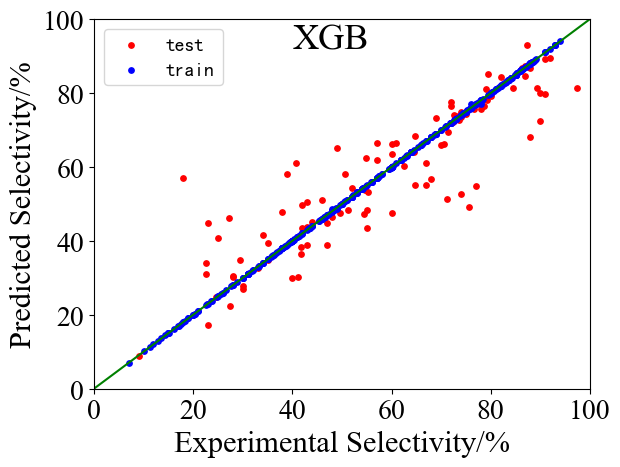

In [9]:
plt.scatter(pred_show.iloc[:,1],pred_show.iloc[:,0],color='r',s=15,label='test')
plt.scatter(pred_show_1.iloc[:,1],pred_show_1.iloc[:,0],color='b',s=15,label='train')
plt.xlim((0,100))
plt.xlabel('Experimental Selectivity/%',fontsize=22,font=Path('..\TimesNewRoman.ttf'))
plt.xticks(fontsize=20,fontname='Times New Roman')
plt.ylim((0,100))
plt.ylabel('Predicted Selectivity/%',fontsize=22,font=Path('..\TimesNewRoman.ttf'))
plt.yticks(fontsize=20,fontname='Times New Roman')
plt.plot([0,100],[0,100],color='g')
plt.text(40,92,'XGB',fontsize=26,font=Path('..\TimesNewRoman.ttf'))
plt.legend(fontsize=14)
plt.show()